# H1: Human 7DoF Reach and Grasp

H1 is a dataset that was collected for open loop calibration of a BCI for robot arm control. The dataset contains neural activity of a human participant as attempting a reach and grasp with their right hand according to visually cued motion for 7 degrees of freedom (DoF). The visual cue was a screen illustrating the desired motion on a virtual arm, and the participant has had practice following these cues to calibrate similar decoders before this dataset was collected.

The data was collected by Sharlene Flesher and Jen Collinger as part of their study on the effects of stimulation for control ([Flesher 21]((https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8715714/))), but these datasets do not include stimulation. A protocol similar to the one used here is described e.g. in [Collinger 13](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(12)61816-9/fulltext), [Wodlinger 14](https://iopscience.iop.org/article/10.1088/1741-2560/12/1/016011#jne505388f1).

## Task 
The virtual arm movement occurs in phases as indicated in the following screenshot. Each phase begins with a presentation of a combo visual and word cue for a particular movement, so the participant can prepare an imagined movement, and an audio go cue to execute the imagined movement.

The screenshot is taken from the Virtual Integration Environment developed by Johns Hopkins University Applied Physics Laboratory ([Wodlinger 14](https://iopscience.iop.org/article/10.1088/1741-2560/12/1/016011)), and Supplement 5 demonstrates a full video of this task. Note that the actual configuration of the virtual environment differed slightly from samples shown.

This dataset provides 2 training datasets, 2 short term test datasets, and 2 long term test datasets. Their timeline is also shown in the next cell.

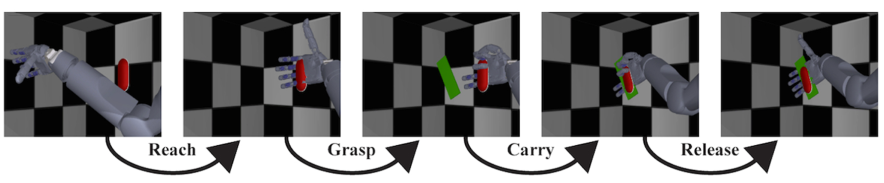

In [1]:
from IPython.display import display, Image
display(Image(filename="data_demos/imgs/h1.png", embed=True))

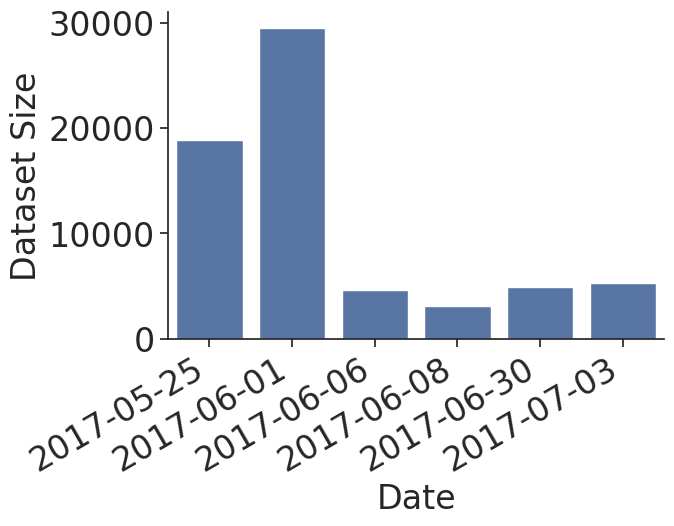

In [29]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import numpy as np
from pynwb import NWBHDF5IO
from data_demos.styleguide import set_style
set_style()

data_dir = Path("data/h1/")

train_query = 'train'
test_query_short = 'test_short'
test_query_long = 'test_long'

def get_files(query):
    if 'test' in query:
        return sorted(list((data_dir / query).glob('*calibration.nwb')))
    return sorted(list((data_dir / query).glob('*.nwb')))
train_files = get_files(train_query)
test_files_short = get_files(test_query_short)
test_files_long = get_files(test_query_long)

sample_files = [
    *train_files,
    *test_files_short,
    *test_files_long
]

def get_start_date_and_volume(fn: Path):
    with NWBHDF5IO(fn, 'r') as io:
        nwbfile = io.read()
        start_date = nwbfile.session_start_time.strftime('%Y-%m-%d') # full datetime to just date
        return pd.to_datetime(start_date), nwbfile.acquisition['OpenLoopKinematics'].timestamps.shape[0]
start_dates, volume = zip(*[get_start_date_and_volume(fn) for fn in sample_files])

# Convert to pandas dataframe for easier manipulation
df = pd.DataFrame({'Date': start_dates, 'Dataset Size': volume})

fig, ax = plt.subplots()

# Scatter plot for visualizing each start date on the same y-value
sns.barplot(x='Date', y='Dataset Size', data=df, ax=ax, order=df['Date'].sort_values(), estimator=np.sum, errorbar=None)

fig.autofmt_xdate()  # Rotate dates for readability

## Quick overview
The primary data acquired are the neural activity and kinematics, but the released datasets include some metadata of the experimental trial structure.
For example, while the calibration block is one continuous block of time, the block is still divided into phases of presentation and movement. The presentation phases indicate to the participant which motion should be attempted.

Let's view the raw data as acquired in the experiment.

In [30]:
from typing import List, Tuple
from falcon_challenge.dataloaders import bin_units

# Batch load all data for subsequent cells

def load_nwb(fn: str):
    r"""
        Load NWB for H1.
    """
    with NWBHDF5IO(fn, 'r') as io:
        nwbfile = io.read()
        units = nwbfile.units.to_dataframe()
        kin = nwbfile.acquisition['OpenLoopKinematics'].data[:]
        timestamps = nwbfile.acquisition['OpenLoopKinematics'].timestamps[:]
        blacklist = nwbfile.acquisition['Blacklist'].data[:].astype(bool)
        epochs = nwbfile.epochs.to_dataframe()
        trials = nwbfile.acquisition['TrialNum'].data[:]
        labels = [l.strip() for l in nwbfile.acquisition['OpenLoopKinematics'].description.split(',')]
        return (
            bin_units(units, bin_end_timestamps=timestamps),
            kin,
            timestamps,
            blacklist,
            epochs,
            trials,
            labels
        )

def load_files(files: list) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.DataFrame, np.ndarray]:
    r"""
        Load several, merge data by simple concat
    """
    
    binned, kin, timestamps, blacklist, epochs, trials, labels = zip(*[load_nwb(str(f)) for f in files])
    lengths = [binned.shape[0] for binned in binned]
    binned = np.concatenate(binned, axis=0)
    kin = np.concatenate(kin, axis=0)
    
    # Offset timestamps and epochs
    bin_size = timestamps[0][1] - timestamps[0][0]
    all_timestamps = [timestamps[0]]
    for current_epochs, current_times in zip(epochs[1:], timestamps[1:]):
        clock_offset = all_timestamps[-1][-1] + bin_size
        current_epochs['start_time'] += clock_offset
        current_epochs['stop_time'] += clock_offset
        all_timestamps.append(current_times + clock_offset)
    timestamps = np.concatenate(all_timestamps, axis=0)
    blacklist = np.concatenate(blacklist, axis=0)
    trials = np.concatenate(trials, axis=0)
    epochs = pd.concat(epochs, axis=0)
    for l in labels[1:]:
        assert l == labels[0]
    return binned, kin, timestamps, blacklist, epochs, trials, labels[0], lengths

binned_neural, all_kin, all_timestamps, all_blacklist, all_epochs, all_trials, all_labels, lengths = load_files(sample_files)
BIN_SIZE_S = all_timestamps[1] - all_timestamps[0]
BIN_SIZE_MS = BIN_SIZE_S * 1000
print(f"Bin size = {BIN_SIZE_S} s")
print(f"Neural data ({len(lengths)} days) of shape T={binned_neural.shape[0]}, N={binned_neural.shape[1]}")

train_bins, train_kin, train_timestamps, train_blacklist, train_epochs, train_trials, train_labels, _ = load_files(train_files)
test_bins_short, test_kin_short, test_timestamps_short, test_blacklist_short, test_epochs_short, test_trials_short, test_labels_short, _ = load_files(test_files_short)
test_bins_long, test_kin_long, test_timestamps_long, test_blacklist_long, test_epochs_long, test_trials_long, test_labels_long, _ = load_files(test_files_long)

sample_bins, sample_kin, sample_timestamps, sample_blacklist, sample_epochs, sample_trials, sample_labels, _ = load_files(sample_files[:1])

Bin size = 0.02 s
Neural data (13 days) of shape T=66234, N=176


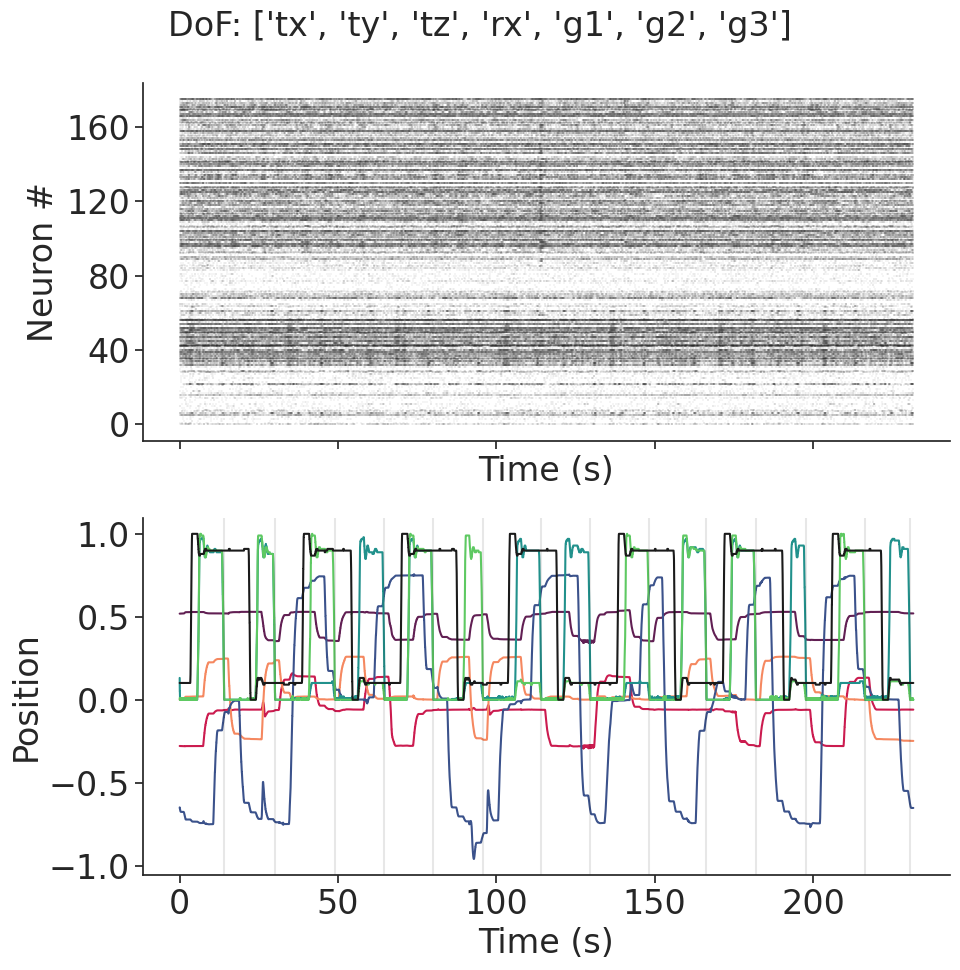

In [31]:
# Overview qualitative
palette = [*sns.color_palette('rocket', n_colors=3), *sns.color_palette('viridis', n_colors=3), 'k']
to_plot = train_labels

all_tags = [tag for sublist in train_epochs['tags'] for tag in sublist]
all_tags.extend([tag for sublist in test_epochs_short['tags'] for tag in sublist])
all_tags.extend([tag for sublist in test_epochs_long['tags'] for tag in sublist])
unique_tags = list(set(all_tags))

def rasterplot(spike_arr: np.ndarray, bin_size_s=BIN_SIZE_S, ax=None):
    if ax is None:
        ax = plt.gca()
    for idx, unit in enumerate(spike_arr.T):
        ax.scatter(np.where(unit)[0] * bin_size_s, np.ones(np.sum(unit != 0)) * idx, s=1, c='k', marker='|', linewidths=0.2, alpha=0.3)
    ax.set_yticks(np.arange(0, spike_arr.shape[1], 40))
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neuron #')

def kinplot(kin, timestamps, ax=None, palette=None, reference_labels=[], to_plot=to_plot, **kwargs):
    if ax is None:
        ax = plt.gca()

    if palette is None:
        palette = plt.cm.viridis(np.linspace(0, 1, len(reference_labels)))
    for kin_label in to_plot:
        kin_idx = reference_labels.index(kin_label)
        ax.plot(timestamps, kin[:, kin_idx], color=palette[kin_idx], **kwargs)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Kinematics')

def plot_qualitative(
    binned: np.ndarray,
    kin: np.ndarray,
    timestamps: np.ndarray,
    epochs: pd.DataFrame,
    trials: np.ndarray,
    labels: list,
    palette: list,
    to_plot: list,
):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    rasterplot(binned, ax=ax1)
    kinplot(kin, timestamps, palette=palette, ax=ax2, reference_labels=labels, to_plot=to_plot)
    ax2.set_ylabel('Position')
    trial_changept = np.where(np.diff(trials) != 0)[0]
    for changept in trial_changept:
        ax2.axvline(timestamps[changept], color='k', linestyle='-', alpha=0.1)
    fig.suptitle(f'DoF: {labels}')
    fig.tight_layout()
    return fig, (ax1, ax2)

f, axes = plot_qualitative(
    sample_bins,
    sample_kin,
    sample_timestamps,
    sample_epochs,
    sample_trials,
    sample_labels,
    palette,
    to_plot
)


## Trial and Kinematic Structure

The order of kinematics conveyed in each trial are randomly generated, but each individual motion's kinematic profile is stereotyped as it was programmatically generated. Inaccuracies in simulator physics leads to some jitter in the reported kinematic traces. Before each upcoming motion, the participant sees a cue that indicates what motion should be executed. We shade these presentation phases in grey in the following cell. Movement phases are generally but not always restricted to one degree of freedom.

This dataset has 7 degrees of freedom in kinematics. There are 3 translation dimensions, 1 orientation dimension, and 3 dimensions for grasp shaping. Data is provided at 50Hz.

We specify smoothed kinematic velocities as decoder targets (rather than position). Here we show their creation, but in practice the preprocessed velocities are available directly in the notebook.

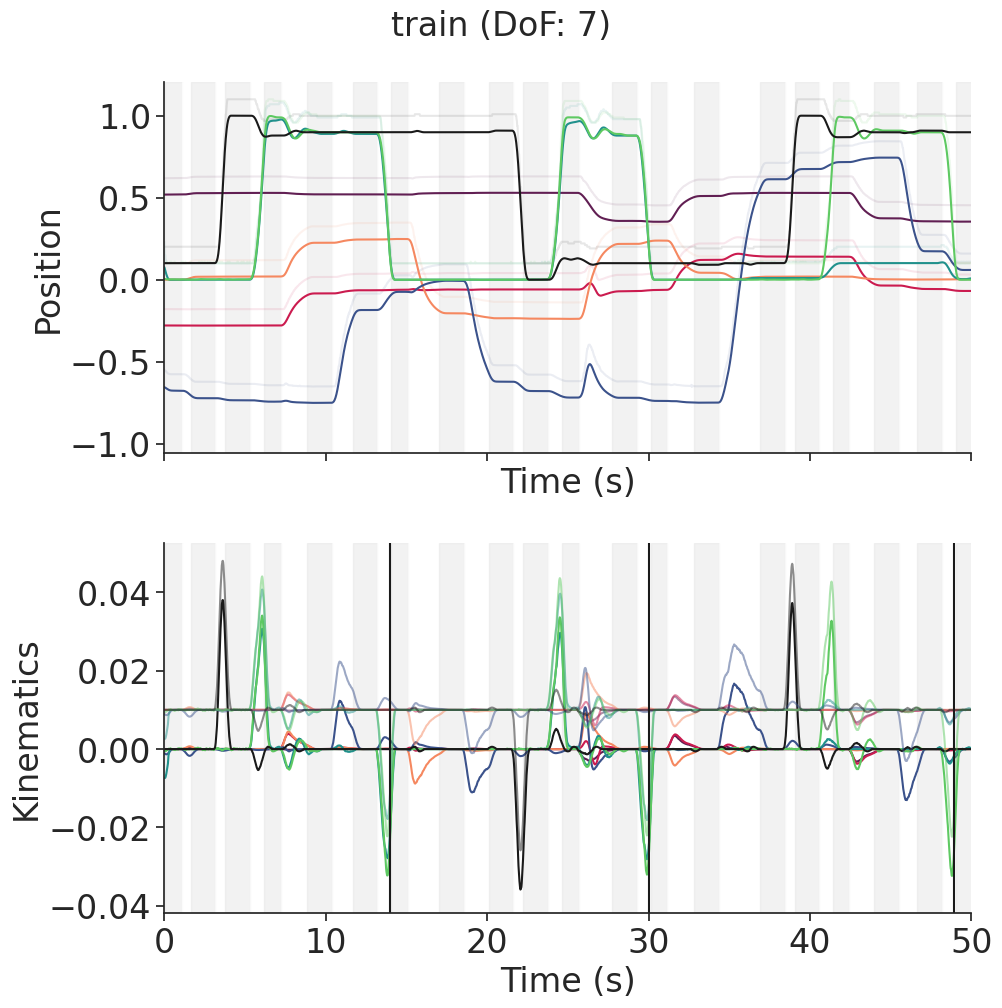

In [32]:
from data_demos.filtering import smooth

DEFAULT_TARGET_SMOOTH_MS = 490
KERNEL_SIZE = int(DEFAULT_TARGET_SMOOTH_MS / BIN_SIZE_MS)
KERNEL_SIGMA = DEFAULT_TARGET_SMOOTH_MS / (3 * BIN_SIZE_MS)
palette = [*sns.color_palette('rocket', n_colors=3), *sns.color_palette('viridis', n_colors=3), 'k']

epoch_palette = sns.color_palette(n_colors=len(unique_tags))

# Mute colors of "Presentation" phases
for idx, tag in enumerate(unique_tags):
    if 'Presentation' in tag:
        epoch_palette[idx] = (0.9, 0.9, 0.9, 0.1)
    else:
        # white
        epoch_palette[idx] = (1, 1, 1, 0.5)

def epoch_annote(epochs, ax=None):
    if ax is None:
        ax = plt.gca()
    for _, epoch in epochs.iterrows():
        epoch_idx = unique_tags.index(epoch.tags[0])
        ax.axvspan(epoch['start_time'], epoch['stop_time'], color=epoch_palette[epoch_idx], alpha=0.5)


fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
def plot_kin_pos(kin, timestamps, labels, epochs, ax, offset_y=0.1, offset_a=0.1):
    kinplot(kin + offset_y, timestamps, palette=palette, ax=ax, reference_labels=labels, alpha=offset_a)
    kinplot(smooth(kin, KERNEL_SIZE, KERNEL_SIGMA), timestamps, ax=ax, palette=palette, reference_labels=labels) # Offset for visual clarity
    ax.set_ylabel('Position')
    epoch_annote(epochs, ax=ax)
plot_kin_pos(sample_kin, sample_timestamps, sample_labels, sample_epochs, ax=axes[0])
plt.suptitle(f'{train_query} (DoF: {len(sample_labels)})')
plt.tight_layout()

def create_targets(kin: np.ndarray, target_smooth_ms=DEFAULT_TARGET_SMOOTH_MS, bin_size_ms=BIN_SIZE_MS, sigma=3):
    kernel_size = int(target_smooth_ms / bin_size_ms)
    kernel_sigma = target_smooth_ms / (sigma * bin_size_ms)
    kin = smooth(kin, kernel_size, kernel_sigma)
    out = np.gradient(kin, axis=0)
    return out

velocity = create_targets(sample_kin, bin_size_ms=BIN_SIZE_MS)  # Simple velocity estimate
kinplot(velocity, sample_timestamps, ax=axes[1], palette=palette, reference_labels=sample_labels)
epoch_annote(sample_epochs, ax=axes[1])

def get_nwb_velocity(fn):
    with NWBHDF5IO(fn, 'r') as io:
        nwbfile = io.read()
        kin = nwbfile.acquisition['OpenLoopKinematicsVelocity'].data[:]
        return kin
velocity_payload = get_nwb_velocity(sample_files[0])
kinplot(velocity_payload + 0.01, sample_timestamps, ax=axes[1], palette=palette, reference_labels=sample_labels, linestyle='-', alpha=0.5)

trial_changept = np.where(np.diff(sample_trials) != 0)[0]
for changept in trial_changept:
    axes[1].axvline(sample_timestamps[changept], color='k', linestyle='-', alpha=1.0)

xticks = np.arange(0, 50, 10)
ax.set_xlim(xticks[0], xticks[-1])
ax.set_xticks(xticks, labels=xticks.round(2))

xticks = np.arange(0, 60, 10)
plt.xlim(xticks[0], xticks[-1])
plt.xticks(xticks, labels=xticks.round(2))

plt.show()


## Neural activity statistics change over time
The neural activity in these datasets are recorded on the Utah array implanted in the motor cortex of the participant. Multunit threshold crossings, putatively attributed to nearby spiking activiy, are extracted when the voltage on an electrode exceed -4.5x the RMS of baseline activity. This threshold is recalibrated daily.

The statistics of neural activity are stable over the course of a single calibration period, but can be quite unstable over the course of multiple days. We see that simply by plotting the raw neural activity from consecutive days together. Instabilities can for example be attributed by given channels being more or less active on a given day, even though these channels _provide decoding signal_ on that day.

Text(0.5, 1.0, 'Firing Rate Distribution per day')

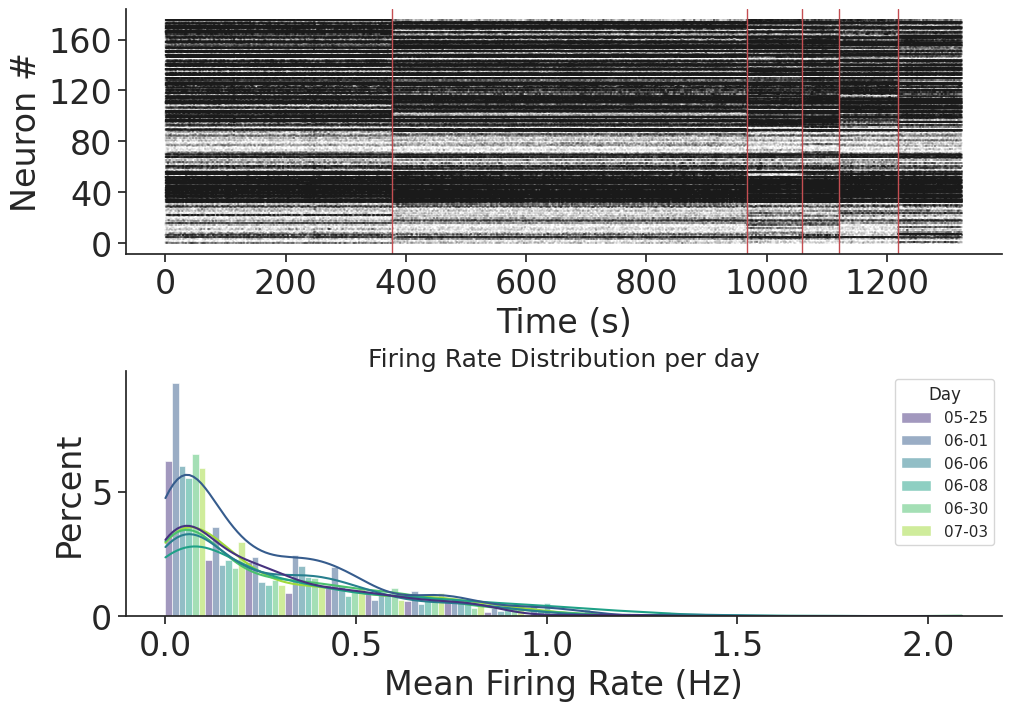

In [33]:
# Plot multiple days back to back to note change in structure

f, axes = plt.subplots(2, 1, figsize=(10, 7), layout='constrained')

rasterplot(binned_neural, ax=axes[0])
day_intervals = np.cumsum(lengths)
for i, length in enumerate(day_intervals[:-1]):
    if start_dates[i] == start_dates[i + 1]:
        continue 
    axes[0].axvline(length * BIN_SIZE_S, color='r', linewidth=1)

# Plot mean firing rates in different days
daily_means = []
day_intervals = [0, *np.cumsum(lengths)]
for start, end in zip(day_intervals[:-1], day_intervals[1:]):
    daily_means.append(np.mean(binned_neural[start:end], axis=0))
# daily_means is a list of 8 arrays, each of shape (N,) - histplot them separately using sns and pd
flattened_data = {'Day': [], 'Mean Firing Rate (Hz)': []}
for day, means in zip(start_dates, daily_means):
    flattened_data['Day'].extend([day.strftime('%m-%d')] * len(means))  # Extend day labels - reformat for simplicity
    flattened_data['Mean Firing Rate (Hz)'].extend(means)  # Extend mean firing rates
    
axes[1] = sns.histplot(data=flattened_data, x='Mean Firing Rate (Hz)', hue='Day', kde=True, ax=axes[1], palette='viridis', bins=20, stat='percent', multiple='dodge')
axes[1].set_title('Firing Rate Distribution per day', ha='center', va='center', transform=axes[1].transAxes, fontsize=18)


## Training and Evaluating a Linear Decoder

The benchmark measures decoding performance from neural data. While many prior works have shown the use of nonlinear decoders for offline decoding, linear decoders remain a common method for decoding motor activity from neural data. For this specific domain of high dimensional control, linear decoders remain the dominant method; recipes for nonlinear decoders are not as well established. 

A minimal exponential decay filter enables ridge regression from neural activity - we visualize its effect in the next cell.

Note that because these kinematic labels are not recordings of actual motion, not all timepoints in the kinematic data are valid. For example, inter-trial periods dictate zero motion, but the participant is not constrained in these periods. We provide a mask for active timepoints to use for decoder training.

Text(0.5, 0.01, 'Time (s)')

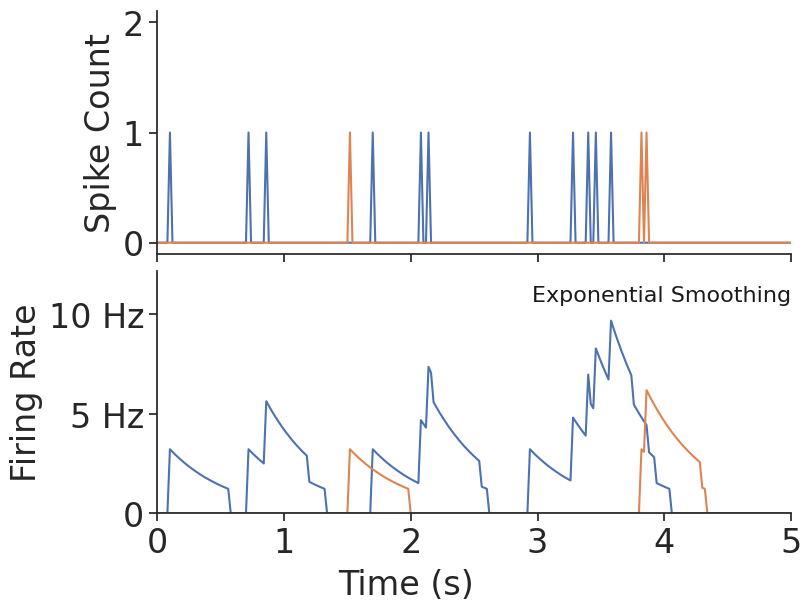

In [34]:
from data_demos.filtering import apply_exponential_filter
filtered_signal = apply_exponential_filter(train_bins)

channels_to_plot = [1, 2]
palette = sns.color_palette(n_colors=len(channels_to_plot))

f, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, layout='constrained')

def plot_filtered(channels_to_plot, ax):
    for i, channel in enumerate(channels_to_plot):
        ax.plot(train_timestamps, filtered_signal[:, channel], color=palette[i])
    ax.set_ylabel('Firing Rate')
    yticks = ax.get_yticks()
    ax.set_yticks(yticks)
    ax.set_ylim(0, filtered_signal[:, channels_to_plot].max() * 1.1)
    labels = [f'{y * (1000 / BIN_SIZE_MS):.0f} Hz' if y > 0 else '0' for y in yticks]
    ax.set_yticklabels(labels)
    ax.text(1.0, 0.9, 'Exponential Smoothing', ha='right', va='center', transform=ax.transAxes, fontsize=16, color='k')
    

def plot_raw(channels_to_plot, ax):
    for i, channel in enumerate(channels_to_plot):
        ax.plot(train_timestamps, train_bins[:, channel], color=palette[i])
    ax.set_ylabel('Spike Count')

plot_raw(channels_to_plot, axes[0])
plot_filtered(channels_to_plot, axes[1])


axes[0].set_xlim([0, 5])
f.supxlabel('Time (s)')

Invalidating 18367 timepoints in train
Invalidating 4606 timepoints in test
CV Score: 0.30
Val R2 Variance Weighted: 0.373
Train R2 Variance Weighted: 0.388


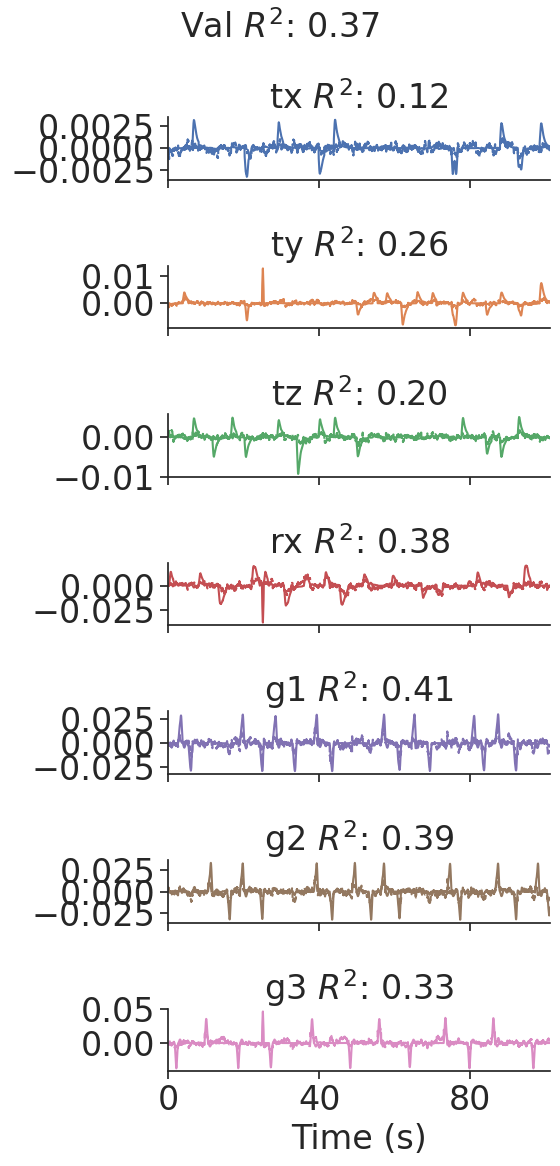

In [35]:
from sklearn.metrics import r2_score
from data_demos.decoding_utils import (
    TRAIN_TEST,
    generate_lagged_matrix,
    fit_and_eval_decoder,
)

def prepare_train_test(
        binned_spikes: np.ndarray,
        behavior: np.ndarray,
        blacklist: np.ndarray | None=None,
        history: int=0,
        ):
    signal = apply_exponential_filter(binned_spikes)
    targets = create_targets(behavior)

    # Remove timepoints where nothing is happening in the kinematics
    still_times = np.all(np.abs(targets) < 0.001, axis=1)
    if blacklist is not None:
        blacklist = still_times | blacklist
    else:
        blacklist = still_times

    train_x, test_x = np.split(signal, [int(TRAIN_TEST[0] * signal.shape[0])])
    train_y, test_y = np.split(targets, [int(TRAIN_TEST[0] * targets.shape[0])])
    train_blacklist, test_blacklist = np.split(blacklist, [int(TRAIN_TEST[0] * blacklist.shape[0])])

    x_mean, x_std = np.nanmean(train_x, axis=0), np.nanstd(train_x, axis=0)
    x_std[x_std == 0] = 1
    y_mean, y_std = np.nanmean(train_y[~train_blacklist], axis=0), np.nanstd(train_y[~train_blacklist], axis=0)
    y_std[y_std == 0] = 1
    train_x = (train_x - x_mean) / x_std
    test_x = (test_x - x_mean) / x_std
    # Note closed form ridge regression doesn't benefit from target rescaling, and we want to evaluate in native scale, variance weighted
    # train_y = (train_y - y_mean) / y_std 
    # test_y = (test_y - y_mean) / y_std

    train_blacklist = train_blacklist | np.isnan(train_y).any(axis=1)
    test_blacklist = test_blacklist | np.isnan(test_y).any(axis=1)
    if np.any(train_blacklist):
        print(f"Invalidating {np.sum(train_blacklist)} timepoints in train")
    if np.any(test_blacklist):
        print(f"Invalidating {np.sum(test_blacklist)} timepoints in test")

    if history > 0:
        train_x = generate_lagged_matrix(train_x, history)
        test_x = generate_lagged_matrix(test_x, history)
        train_y = train_y[history:]
        test_y = test_y[history:]
        if blacklist is not None:
            train_blacklist = train_blacklist[history:]
            test_blacklist = test_blacklist[history:]

    # Now, finally, remove by blacklist
    train_x = train_x[~train_blacklist]
    train_y = train_y[~train_blacklist]
    test_x = test_x[~test_blacklist]
    test_y = test_y[~test_blacklist]

    return train_x, train_y, test_x, test_y, x_mean, x_std, y_mean, y_std

HISTORY = 0
# HISTORY = 5

(
    train_x,
    train_y,
    test_x,
    test_y,
    x_mean,
    x_std,
    y_mean,
    y_std
) = prepare_train_test(train_bins, train_kin, train_blacklist, history=HISTORY)

score, decoder = fit_and_eval_decoder(train_x, train_y, test_x, test_y)
print(f"CV Score: {score:.2f}")

# Same-day eval
pred_y = decoder.predict(test_x)
train_pred_y = decoder.predict(train_x)

r2 = r2_score(test_y, pred_y, multioutput='raw_values')
r2_weighted = r2_score(test_y, pred_y, multioutput='variance_weighted')
train_r2 = r2_score(train_y, train_pred_y, multioutput='variance_weighted')
print(f"Val R2 Variance Weighted: {r2_weighted:.3f}")
print(f"Train R2 Variance Weighted: {train_r2:.3f}")

palette = sns.color_palette(n_colors=train_kin.shape[1])
f, axes = plt.subplots(train_kin.shape[1], figsize=(6, 12), sharex=True)
# Plot true vs predictions
for idx, (true, pred) in enumerate(zip(test_y.T, pred_y.T)):
    axes[idx].plot(true, label=f'{idx}', color=palette[idx])
    axes[idx].plot(pred, linestyle='--', color=palette[idx])
    axes[idx].set_title(f"{train_labels[idx]} $R^2$: {r2[idx]:.2f}")
    xticks = axes[idx].get_xticks()
    axes[idx].set_xticks(xticks)
    axes[idx].set_xticklabels([f'{x/1000 * BIN_SIZE_MS:.0f}' for x in xticks])
axes[-1].set_xlim(0, test_y.shape[0])
axes[-1].set_xlabel('Time (s)')
f.suptitle(f'Val $R^2$: {r2_weighted:.2f}')
f.tight_layout()


## Multi-day decoding
FALCON evaluates decoder performance on novel days. Current decoders, including the simple linear decoder we train here, have trivial performance when applied naively to new days, even accounting for mean firing rate shifts. Real world performance thus requires advances in multi-day transfer, whether this comes from better base models, better calibration methods, or better test-time adaptation.

In [37]:
def prepare_test(
        binned_spikes: np.ndarray,
        behavior: np.ndarray,
        x_mean: np.ndarray,
        x_std: np.ndarray,
        y_mean: np.ndarray,
        y_std: np.ndarray,
        use_local_x_stats: bool = True, # Minimal adaptation is to zscore with local statistics
        history: int=0,
        blacklist: np.ndarray | None=None,
        ):
    signal = apply_exponential_filter(binned_spikes)
    targets = create_targets(behavior)

    # Remove timepoints where nothing is happening in the kinematics - not good for eval
    if blacklist is None:
        blacklist = np.zeros(targets.shape[0], dtype=bool)

    if use_local_x_stats:
        x_mean = np.nanmean(signal[~blacklist], axis=0)
        x_std = np.nanstd(signal[~blacklist], axis=0)
        x_std[x_std == 0] = 1
    signal = (signal - x_mean) / x_std
    # targets = (targets - y_mean) / y_std

    is_nan_y = np.isnan(targets).any(axis=1)
    if np.any(is_nan_y):
        print(f"NaNs found in test_y, removing {np.sum(is_nan_y)} timepoints")
        blacklist = blacklist | is_nan_y

    if history > 0:
        signal = generate_lagged_matrix(signal, history)
        targets = targets[history:]
        blacklist = blacklist[history:]

    signal = signal[~blacklist]
    targets = targets[~blacklist]

    return signal, targets

# Multi-day eval
x_short, y_short = prepare_test(
    test_bins_short,
    test_kin_short,
    x_mean,
    x_std,
    y_mean,
    y_std,
    history=HISTORY,
    # use_local_x_stats=False,
    blacklist=test_blacklist_short
    )
x_long, y_long = prepare_test(
    test_bins_long,
    test_kin_long,
    x_mean,
    x_std,
    y_mean,
    y_std,
    history=HISTORY,
    # use_local_x_stats=False,
    blacklist=test_blacklist_long
    )

r2_uniform_short = r2_score(y_short, decoder.predict(x_short), multioutput='variance_weighted')
r2_uniform_long = r2_score(y_long, decoder.predict(x_long), multioutput='variance_weighted')
print(f"Short Zero-shot: {r2_uniform_short:.2f}")
print(f"Long Zero-shot: {r2_uniform_long:.2f}")


Short Zero-shot: 0.06
Long Zero-shot: 0.01
